## 10/8の進捗報告用 notebook

- このノートブックでの解析の流れを元に再度ワークフローを組み直す予定

1. ドメイン情報の検証 (InterProのIDと一致するかどうか)
2. マウスの遺伝子発現データとの統合
3. 発現下降遺伝子群の検証

In [1]:
import re
import datetime
import pathlib
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
VERSION = datetime.datetime.now().strftime("%y%m%d")
print(VERSION)

241006


In [3]:
foldseek_result_tsv = "../out/rice_down/foldseek_rice_down_9606.tsv"

### 1. foldseekの結果から "main target species" の結果を選抜する

- ヒトのヒットを選抜する

In [4]:
foldseek_result = pl.read_csv(
    foldseek_result_tsv,
    separator='\t'
)

display(foldseek_result)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str
"""Os01g0137950""","""A0A0P0UXR3""","""K7EP59""",0.001585,1.0,11,16.9,0.169,36,12,204,204,172,361,432,213,0.946,0.44,0.5168,0.4548,0.2316,0.4883,21.03,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""IIHFDIKPQNILLDQDFCPKIADFGLAKLC…","""IVHKDIKPGNLLLTTGGTLKISDLGVAEAL…",134,"""0.628,0.669,0.730,0.738,0.821,…"
"""Os01g0179600""","""B7FAP2""","""Q5DT01""",2.4880e-15,1.0,28,15.8,0.158,84,10,486,487,25,469,534,531,0.979,0.833,0.5143,0.6251,0.5752,0.6787,6.307,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ANEAHHFLVVTYPAQGHINPARHLARRLAR…","""WAESGKVLVV-PIDGSHWLSMREVLREL--…",307,"""0.544,0.475,0.523,0.579,0.642,…"
"""Os01g0179600""","""B7FAP2""","""I6VBT8""",7.8850e-16,1.0,29,14.0,0.14,76,7,486,487,21,468,533,541,0.986,0.841,0.5018,0.5958,0.5495,0.6433,7.547,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""EAVANEAHHFLVVTYPAQGHINPARHLARR…","""GPVVSHAGKILLI-PVDGSHWLS--MLGAI…",311,"""0.425,0.538,0.597,0.721,0.633,…"
"""Os01g0179600""","""B7FAP2""","""I6VBU3""",8.3290e-16,1.0,29,13.6,0.136,74,7,486,487,21,468,533,541,0.986,0.841,0.4991,0.5944,0.5481,0.6415,7.103,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""EAVANEAHHFLVVTYPAQGHINPARHLARR…","""GPVVSHAGKILLI-PVDGSHWLS--MLGAI…",313,"""0.350,0.519,0.583,0.721,0.625,…"
"""Os01g0179600""","""B7FAP2""","""Q5DSZ9""",9.8150e-16,1.0,28,14.3,0.143,76,10,486,487,25,469,534,529,0.979,0.833,0.4968,0.597,0.5506,0.6486,7.196,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ANEAHHFLVVTYPAQGHINPARHLARRLAR…","""WAESGKVLVV-PTDGSHWLSMRE--ALRDL…",317,"""0.529,0.508,0.555,0.579,0.642,…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,0.821,0.807,0.5904,0.5441,0.4651,0.6474,6.032,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""DKLITLQPVVRACVFLATAVAAVIM-----…","""NNFLFAQCACYFLAFLFSFVVVVPLSENGH…",133,"""0.393,0.528,0.556,0.494,0.483,…"
"""Os12g0610800""","""Q0ILZ7""","""Q7Z7N9""",0.04982,1.0,8,14.2,0.142,29,25,193,195,6,198,219,203,0.867,0.881,0.6059,0.5875,0.53,0.6709,6.828,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LITLQPVVRACVFLATAVAAVIM-------…","""LQRVELALFAAAFLCGAVAAAAMTRTQGSF…",130,"""0.569,0.555,0.483,0.653,0.673,…"
"""Os12g0610800""","""Q0ILZ7""","""O43761""",0.06753,1.0,4,12.0,0.12,19,29,185,195,25,170,229,158,0.805,0.638,0.5363,0.4562,0.4006,0.5802,6.696,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""QPVVRACVFLATAVAAVIMGLNKQSYTTVV…","""QTLLRVASWVFSIAVFGPIVNE------GY…",126,"""0.573,0.650,0.738,0.711,0.708,…"


## 2. すべてのヒットに対してペアワイズアラインメントを (先に) 実行する

- すべてのヒットに対してペアワイズアラインメントを先に実行しておくことで､(すべてのヒットに対する)散布図の作成も可能
- この処理を行う前に､以下の処理を行う

### 1. [32_extract_id.cwl](../Tools/32_extract_id.cwl) で､ヒットしたリストを作成する

In [ ]:
!cwltool --outdir ../out/rice_down/ ../Tools/32_extract_id.cwl ../job/3_extract_id_rice_down.yml

In [ ]:
!cwltool --outdir ../out/rice_down/ ../Tools/32_extract_id.cwl ../job/3_extract_id_human_down.yml

### 2. [33_blastdbcmd.cwl](../Tools/33_blastdbcmd.cwl) で､ヒットしたリストのfastaファイルを抽出する

In [ ]:
!cwltool --outdir ../out/rice_down/ ../Tools/33_blastdbcmd.cwl ../job/3_blastdbcmd_rice_down.yml

In [ ]:
!cwltool --outdir ../out/rice_down/ ../Tools/33_blastdbcmd.cwl ../job/3_blastdbcmd_human_down.yml

### 3. [34_seqretsplit.cwl](../Tools/34_seqretsplit.cwl) で､multi-fastaファイルを個々のファイルにsplitする

In [ ]:
!mkdir -p ../out/rice_down/split_fasta_rice
!cwltool --outdir ../out/rice_down/split_fasta_rice/ ../Tools/34_seqretsplit.cwl ../job/3_seqretsplit_rice_down.yml

In [ ]:
!mkdir -p ../out/rice_down/split_fasta_human
!cwltool --outdir ../out/rice_down/split_fasta_human/ ../Tools/34_seqretsplit.cwl ../job/3_seqretsplit_human_down.yml


### 4. [run_needle.sh](../scripts/run_needle.sh) で､splitしたfastaファイルに対してneedleを実行する (まだCWL化をしていない)

In [ ]:
# !mkdir -p ../out/rice_down/needle_result
# !bash ../scripts/run_needle.sh ../out/rice_down/foldseek_rice_down_9606.tsv ../out/rice_down/split_fasta_rice/ ../out/rice_down/split_fasta_human/ ../out/rice_down/needle_result/ 2 3


### 5. [run_water.sh](../scripts/run_water.sh) で､splitしたfastaファイルに対してwaterを実行する (まだCWL化をしていない)

In [ ]:
# !mkdir -p ../out/rice_down/water_result
# !bash ../scripts/run_water.sh ../out/rice_down/foldseek_rice_down_9606.tsv ../out/rice_down/split_fasta_rice/ ../out/rice_down/split_fasta_human/ ../out/rice_down/water_result/ 2 3

In [6]:
def parse_needle_water_result(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.readlines()
        
    result = {
        "UniProt Accession": None,
        "foldseek hit": None,
        "Length": None,
        "Identity": None,
        "Identity_percent": None,
        "Similarity": None,
        "Similarity_percent": None,
        "Gaps": None,
        "Gaps_percent": None,
        "Score": None
    }
    
    for line in data:
        if line.startswith('# 1:'):
            result['UniProt Accession'] = line.split(':')[1].strip()
        elif line.startswith('# 2:'):
            result['foldseek hit'] = line.split(':')[1].strip()
        elif line.startswith('# Length:'):
            result['Length'] = int(line.split()[2])
        elif line.startswith('# Identity:'):
            result['Identity'] = line.split()[2]
            result['Identity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Similarity:'):
            result['Similarity'] = line.split()[2]
            result['Similarity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Gaps:'):
            result['Gaps'] = line.split()[2]
            result['Gaps_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Score:'):
            result['Score'] = float(line.split()[2])
            
    return result

In [7]:
water_result_dir = pathlib.Path("../out/rice_down/water_result")
needle_result_dir = pathlib.Path("../out/rice_down/needle_result")

# initialize empty dataframe
water_result = pl.DataFrame()
needle_result = pl.DataFrame()

for result_file in water_result_dir.glob("*_align.water"):
    parsed_data = parse_needle_water_result(result_file)
    new_row = pl.DataFrame([parsed_data])
    water_result = pl.concat([water_result, new_row], how='vertical').sort(
        by=["UniProt Accession", "foldseek hit"],
        descending=[False, False]
    )
    
for result_file in needle_result_dir.glob("*_align.needle"):
    parsed_data = parse_needle_water_result(result_file)
    new_row = pl.DataFrame([parsed_data])
    needle_result = pl.concat([needle_result, new_row], how='vertical').sort(
        by=["UniProt Accession", "foldseek hit"],
        descending=[False, False]
    )


display(water_result)
display(needle_result)

UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0N7KD90""","""A0A024R6G4""",502,"""153/502""",30.5,"""246/502""",49.0,"""38/502""",7.6,545.0
"""A0A0N7KD90""","""A0A024RAC7""",457,"""124/457""",27.1,"""217/457""",47.5,"""47/457""",10.3,395.0
"""A0A0N7KD90""","""A0A087WUF8""",172,"""44/172""",25.6,"""68/172""",39.5,"""50/172""",29.1,103.0
"""A0A0N7KD90""","""A0A087X192""",244,"""65/244""",26.6,"""97/244""",39.8,"""57/244""",23.4,139.5
"""A0A0N7KD90""","""A0A087X2D4""",475,"""97/475""",20.4,"""159/475""",33.5,"""180/475""",37.9,213.0
…,…,…,…,…,…,…,…,…,…
"""Q9XHX6""","""A0A140T9G8""",104,"""22/104""",21.2,"""33/104""",31.7,"""41/104""",39.4,28.5
"""Q9XHX6""","""A0A1U9X7F4""",104,"""22/104""",21.2,"""33/104""",31.7,"""41/104""",39.4,28.5
"""Q9XHX6""","""Q0P5T2""",104,"""22/104""",21.2,"""33/104""",31.7,"""41/104""",39.4,28.5


UniProt Accession,foldseek hit,Length,Identity,Identity_percent,Similarity,Similarity_percent,Gaps,Gaps_percent,Score
str,str,i64,str,f64,str,f64,str,f64,f64
"""A0A0N7KD90""","""A0A024R6G4""",557,"""155/557""",27.8,"""250/557""",44.9,"""72/557""",12.9,531.0
"""A0A0N7KD90""","""A0A024RAC7""",606,"""137/606""",22.6,"""236/606""",38.9,"""142/606""",23.4,373.0
"""A0A0N7KD90""","""A0A087WUF8""",540,"""48/540""",8.9,"""73/540""",13.5,"""404/540""",74.8,97.0
"""A0A0N7KD90""","""A0A087X192""",527,"""65/527""",12.3,"""98/527""",18.6,"""336/527""",63.8,137.5
"""A0A0N7KD90""","""A0A087X2D4""",557,"""99/557""",17.8,"""162/557""",29.1,"""256/557""",46.0,205.5
…,…,…,…,…,…,…,…,…,…
"""Q9XHX6""","""A0A140T9G8""",533,"""41/533""",7.7,"""68/533""",12.8,"""393/533""",73.7,10.0
"""Q9XHX6""","""A0A1U9X7F4""",415,"""41/415""",9.9,"""68/415""",16.4,"""275/415""",66.3,10.0
"""Q9XHX6""","""Q0P5T2""",653,"""6/653""",0.9,"""7/653""",1.1,"""633/653""",96.9,10.0


In [8]:
alignment_result = water_result.join(
    needle_result,
    on=["UniProt Accession", "foldseek hit"],
    how="inner",
    coalesce=True,
    suffix="_needle"
).rename(
    {
        "Length": "Length_water",
        "Identity": "Identity_water",
        "Identity_percent": "Identity_percent_water",
        "Similarity": "Similarity_water",
        "Similarity_percent": "Similarity_percent_water",
        "Gaps": "Gaps_water",
        "Gaps_percent": "Gaps_percent_water",
        "Score": "Score_water"
    }
).select(
    [
        "UniProt Accession",
        "foldseek hit",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_needle",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_needle",
        "Gaps_percent_water",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
)

display(alignment_result)

UniProt Accession,foldseek hit,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""A0A0N7KD90""","""A0A024R6G4""",502,557,"""153/502""","""155/557""",30.5,27.8,49.0,44.9,"""38/502""","""72/557""",7.6,12.9,545.0,531.0
"""A0A0N7KD90""","""A0A024RAC7""",457,606,"""124/457""","""137/606""",27.1,22.6,47.5,38.9,"""47/457""","""142/606""",10.3,23.4,395.0,373.0
"""A0A0N7KD90""","""A0A087WUF8""",172,540,"""44/172""","""48/540""",25.6,8.9,39.5,13.5,"""50/172""","""404/540""",29.1,74.8,103.0,97.0
"""A0A0N7KD90""","""A0A087X192""",244,527,"""65/244""","""65/527""",26.6,12.3,39.8,18.6,"""57/244""","""336/527""",23.4,63.8,139.5,137.5
"""A0A0N7KD90""","""A0A087X2D4""",475,557,"""97/475""","""99/557""",20.4,17.8,33.5,29.1,"""180/475""","""256/557""",37.9,46.0,213.0,205.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q9XHX6""","""A0A140T9G8""",104,533,"""22/104""","""41/533""",21.2,7.7,31.7,12.8,"""41/104""","""393/533""",39.4,73.7,28.5,10.0
"""Q9XHX6""","""A0A1U9X7F4""",104,415,"""22/104""","""41/415""",21.2,9.9,31.7,16.4,"""41/104""","""275/415""",39.4,66.3,28.5,10.0
"""Q9XHX6""","""Q0P5T2""",104,653,"""22/104""","""6/653""",21.2,0.9,31.7,1.1,"""41/104""","""633/653""",39.4,96.9,28.5,10.0


&nbsp;

&nbsp;


## 3. foldseekの結果とペアワイズアラインメントの結果を結合する

- この時､ **ペアワイズアラインメントの結果がnull､つまり現在のUniProtのエントリーになくobsoleteになっているものは除外する**

In [9]:
join_foldseek = foldseek_result.join(
    alignment_result,
    on=["UniProt Accession", "foldseek hit"],
    how="left",
    coalesce=True
).filter(
    pl.col("Length_water").is_not_null() & 
    pl.col("Length_needle").is_not_null()
).unique()


print(join_foldseek.group_by(["From"]).n_unique())
print(join_foldseek.group_by(["UniProt Accession", "foldseek hit"]).n_unique())
display(join_foldseek.head())


shape: (166, 44)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek  ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit       ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os03g06175 ┆ 1          ┆ 7         ┆ 7      ┆ … ┆ 3         ┆ 7         ┆ 5         ┆ 6         │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os11g06872 ┆ 3          ┆ 22        ┆ 20     ┆ … ┆ 15        ┆ 22       

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os07g0292100""","""A0A0P0X5B5""","""C9J8K7""",0.001171,1.0,7,25.9,0.259,33,16,136,136,2,113,258,127,0.89,0.434,0.6497,0.4011,0.2316,0.4748,9.872,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""LVQLLAAVLFLLPLVYLLFFKGDGNGGVMD…","""LDFAIFAVTFLLALVGAVLYLYPA------…",73,"""0.562,0.526,0.647,0.653,0.735,…",110,281,"""31/110""","""36/281""",28.2,12.8,37.3,17.8,"""33/110""","""168/281""",30.0,59.8,63.0,53.0
"""Os10g0165300""","""Q10A28""","""P20853""",4.1150e-25,1.0,21,21.8,0.218,113,2,501,501,3,494,494,517,0.998,0.996,0.673,0.8228,0.8337,0.8384,4.222,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""ATWILGWLLWLPVFLISLYLVDILAHSCRR…","""ASGLL--LVALLACLTVMVLMSVWQQRKSR…",362,"""0.475,0.455,0.455,0.442,0.446,…",493,531,"""119/493""","""121/531""",24.1,22.8,45.4,43.5,"""50/493""","""67/531""",10.1,12.6,327.0,315.5
"""Os10g0528300""","""Q9FUE4""","""A0A087WWT8""",0.000003,1.0,12,18.6,0.186,46,1,228,239,36,264,296,247,0.954,0.774,0.5566,0.6696,0.5522,0.7015,6.583,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAGSG----DELMLLGKWPSPFVTRVELAL…","""AASPAHWPRESLVLYHWTQSFSSQKVRLVI…",164,"""0.232,0.141,0.170,0.235,0.321,…",235,341,"""47/235""","""50/341""",20.0,14.7,36.2,26.1,"""58/235""","""147/341""",24.7,43.1,82.5,64.5
"""Os08g0547300""","""Q6Z9D5""","""B2R9K2""",1.8940e-21,1.0,26,21.8,0.218,124,3,548,551,1,495,502,567,0.991,0.986,0.6402,0.7586,0.8284,0.8411,6.692,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MDSSPSTQDCGGWLLYVSLAAKCGGDPCRV…","""MDLIP-NLAVETWLL---------------…",350,"""0.500,0.375,0.472,0.450,0.375,…",515,604,"""129/515""","""140/604""",25.0,23.2,40.0,37.3,"""99/515""","""155/604""",19.2,25.7,323.0,316.5
"""Os11g0210600""","""Q0ITW6""","""B4DMQ7""",1.2110e-9,1.0,16,17.9,0.179,37,110,297,297,49,243,243,206,0.633,0.802,0.5721,0.4988,0.5966,0.7521,3.955,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""PPKGCTVAIFG-LGAVGLAAMEGARISGAS…","""VQAGDYVLIHAGLSGVGTAAIQLTRMAGA-…",140,"""0.591,0.661,0.705,0.688,0.717,…",210,340,"""47/210""","""60/340""",22.4,17.6,36.7,29.7,"""67/210""","""140/340""",31.9,41.2,94.5,79.5


## 4. すべてのヒットの散布図を作成する

<Figure size 4000x4000 with 0 Axes>

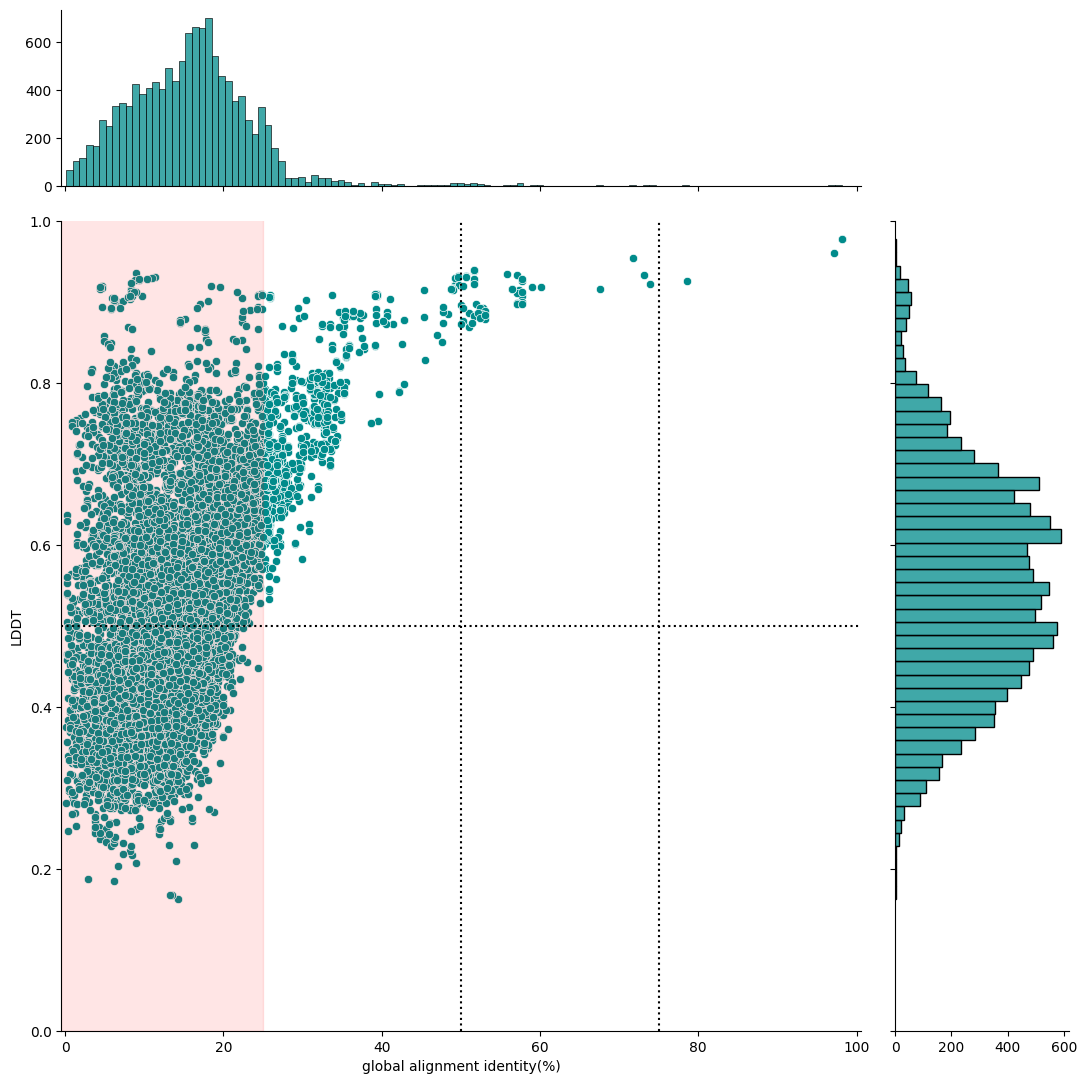

<Figure size 5000x5000 with 0 Axes>

In [10]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=join_foldseek,
    x="Identity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図からレジェンドを削除
# g.legend().remove()

plt.fill_betweenx(
    y=[0, 15],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100.5)
plt.ylim(0,1)
plt.xlabel("global alignment identity(%)")
plt.ylabel("LDDT")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")

# レジェンドを別の図として作成
# legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
# legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# legend_ax.axis('off')
# plt.tight_layout()
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

<Figure size 4000x4000 with 0 Axes>

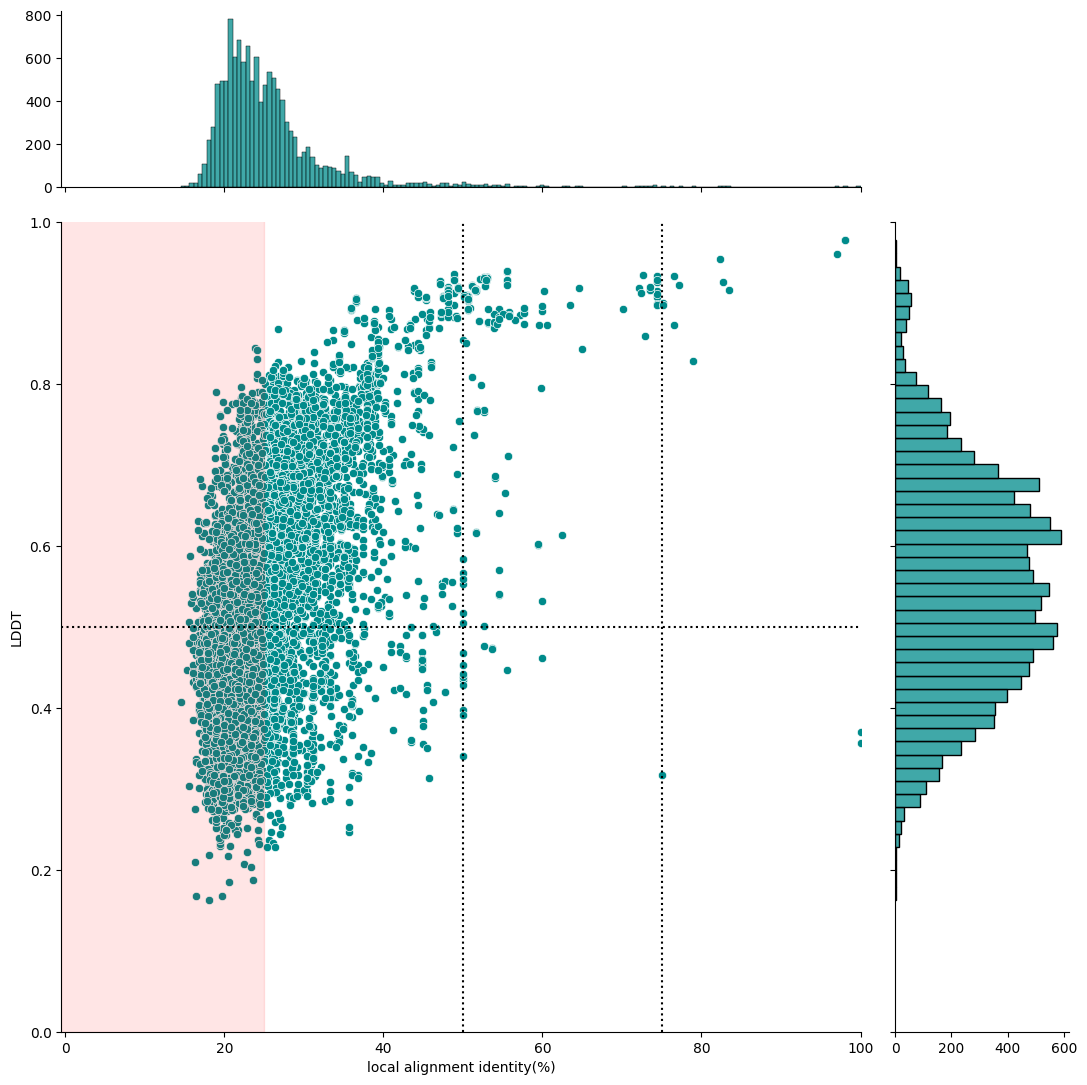

<Figure size 5000x5000 with 0 Axes>

In [11]:
# local alignment
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=join_foldseek,
    x="Identity_percent_water",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図からレジェンドを削除
# g.legend().remove()

plt.fill_betweenx(
    y=[0, 15],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("local alignment identity(%)")
plt.ylabel("LDDT")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")

# レジェンドを別の図として作成
# legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
# legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# legend_ax.axis('off')
# plt.tight_layout()
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

#### 縦軸をカバレッジに変更してみた図

<Figure size 4000x4000 with 0 Axes>

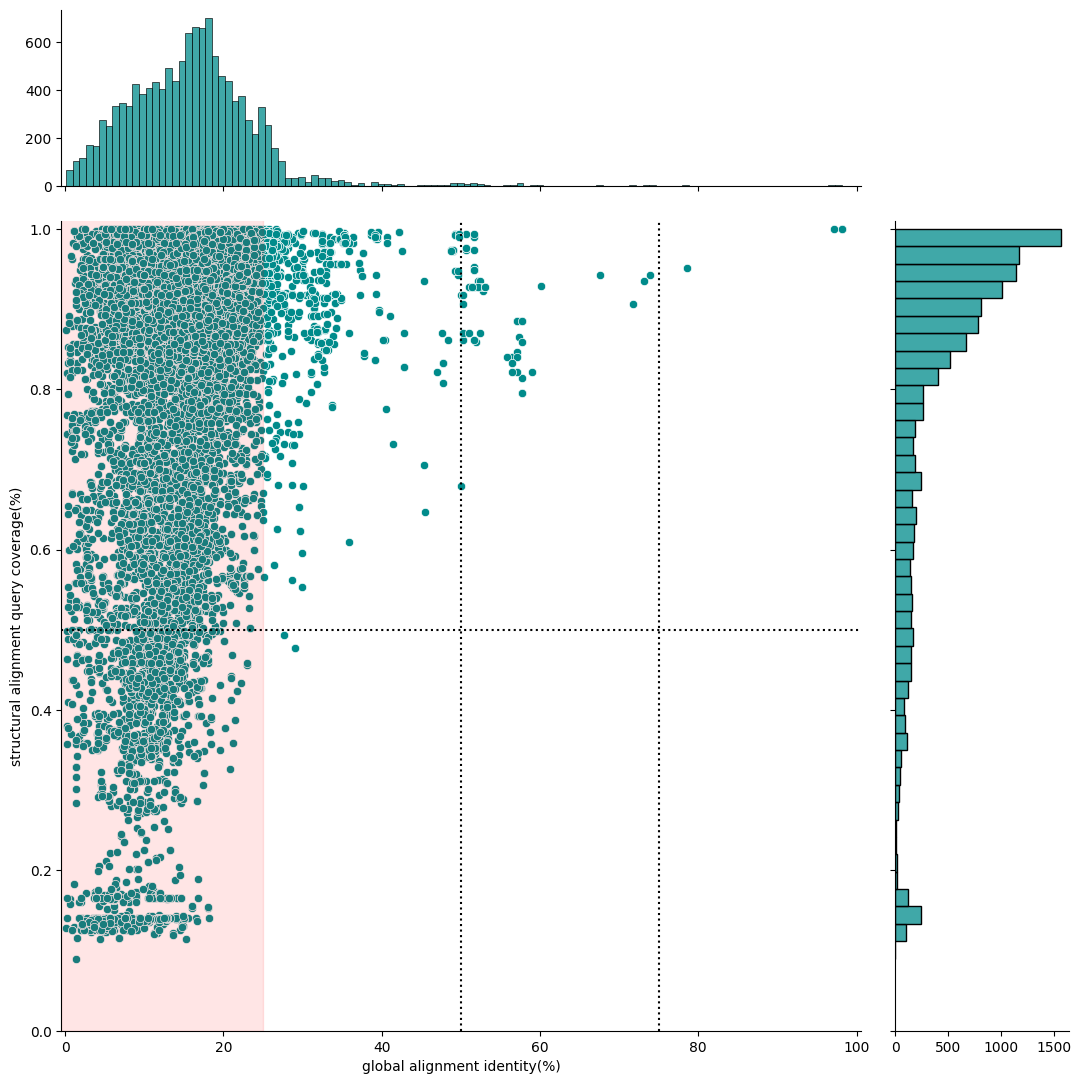

<Figure size 5000x5000 with 0 Axes>

In [12]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=join_foldseek,
    x="Identity_percent_needle",
    y="qcov",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図からレジェンドを削除
# g.legend().remove()

plt.fill_betweenx(
    y=[0, 15],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100.5)
plt.ylim(0,1.01)
plt.xlabel("global alignment identity(%)")
plt.ylabel("structural alignment query coverage(%)")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")

# レジェンドを別の図として作成
# legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
# legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)
# legend_ax.axis('off')
# plt.tight_layout()
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;


## 5. Condition1

- 遺伝子レベルで､foldseekでヒットがないものを選抜する

In [13]:
# 遺伝子レベルでのヒットカウントを算出
all_gene_list = pl.read_csv(
    "../Data/Data_HN5_genelist_rice_2402/HN5_genes_down_rice.tsv",
    separator='\t'
).select(
    "From"
).unique()

hit_count = all_gene_list.join(
    join_foldseek,
    on="From",
    how="left"
).group_by("From").agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)")),
    (pl.col("foldseek hit").is_null().all().alias("foldseek no hit"))
).sort(
    ["hit count (gene level)"], descending=True
)
    
hit_count.write_csv(
    "../out/rice_down/foldseek_rice_down_hit_count.tsv",
    separator='\t'
)

display(hit_count)

From,hit count (gene level),foldseek no hit
str,u32,bool
"""Os03g0833100""",322,false
"""Os04g0453200""",314,false
"""Os12g0512100""",308,false
"""Os03g0760200""",293,false
"""Os01g0591300""",291,false
…,…,…
"""Os07g0258100""",0,true
"""Os05g0349800""",0,true
"""Os02g0579000""",0,true


In [14]:
no_hit_genes_list = hit_count.filter(
    pl.col("foldseek no hit") == True
)

idmapping_list = pl.read_csv(
    "../out/rice_down/rice_down_idmapping.tsv",
    separator='\t'
)
  
no_hit_idmapping_list = no_hit_genes_list.join(
    idmapping_list,
    on="From",
    how="left"
).sort(
    by=["From"],
    descending=[False]
)

print(no_hit_idmapping_list.group_by(["From"]).n_unique())
display(no_hit_idmapping_list.head())

shape: (204, 4)
┌──────────────┬────────────────────────┬─────────────────┬───────────────────┐
│ From         ┆ hit count (gene level) ┆ foldseek no hit ┆ UniProt Accession │
│ ---          ┆ ---                    ┆ ---             ┆ ---               │
│ str          ┆ u32                    ┆ u32             ┆ u32               │
╞══════════════╪════════════════════════╪═════════════════╪═══════════════════╡
│ Os08g0535000 ┆ 1                      ┆ 1               ┆ 2                 │
│ Os05g0478000 ┆ 1                      ┆ 1               ┆ 2                 │
│ Os04g0405900 ┆ 1                      ┆ 1               ┆ 2                 │
│ Os07g0258100 ┆ 1                      ┆ 1               ┆ 1                 │
│ Os11g0592200 ┆ 1                      ┆ 1               ┆ 2                 │
│ …            ┆ …                      ┆ …               ┆ …                 │
│ Os07g0687400 ┆ 1                      ┆ 1               ┆ 2                 │
│ Os02g0779400 ┆ 1      

From,hit count (gene level),foldseek no hit,UniProt Accession
str,u32,bool,str
"""Os01g0105300""",0,true,"""A0A0P0UWX1"""
"""Os01g0136300""",0,true,"""A0A8J8YJH9"""
"""Os01g0136300""",0,true,"""Q5ZC68"""
"""Os01g0137950""",0,true,"""A0A0P0UXR3"""
"""Os01g0216000""",0,true,"""Q0JPL7"""


In [ ]:
## 6. Condition2
# - 遺伝子レベルで見ると少なくとも1つのヒットがあるが､その中で全くヒットしなかったUniProt IDを除外する
# condition2 = join_foldseek.filter(
#         pl.col("foldseek hit").is_not_null()
#     )

# no_hit_uniprot_accession_df = join_foldseek.filter(
#         pl.col("foldseek hit").is_null()
#     )

# display(condition2)
# display(no_hit_uniprot_accession_df)

&nbsp;

&nbsp;


## 7. Condition3

- 同じ遺伝子由来のUniProt IDに対して､同じtargetのヒットがある場合､qcovが最も高いものを選抜する

In [15]:
condition3 = join_foldseek.sort(
        "qcov", descending=True
    ).unique(
        subset=["From", "foldseek hit"]
    ).sort(
        "qcov", descending=True
    )

print(condition3.group_by(["From"]).n_unique())
display(condition3)

shape: (166, 44)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek  ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit       ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os01g02483 ┆ 1          ┆ 5         ┆ 5      ┆ … ┆ 1         ┆ 3         ┆ 1         ┆ 1         │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os03g03073 ┆ 2          ┆ 66        ┆ 60     ┆ … ┆ 40        ┆ 54       

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os05g0475700""","""Q0DHC7""","""A0A1W2PQ13""",0.01109,1.0,29,10.2,0.102,62,1,561,561,255,689,689,607,1.0,0.631,0.44,0.406,0.3369,0.5113,15.23,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MPSPSSAHWLSLVGSVWLQTINGPNADFPV…","""IGSPSVYH---AVIVIFLEFFAWGLLTAPT…",327,"""0.160,0.188,0.228,0.223,0.196,…",603,789,"""126/603""","""134/789""",20.9,17.0,34.5,27.8,"""193/603""","""328/789""",32.0,41.6,89.0,82.5
"""Os10g0528300""","""Q9FUE4""","""Q5TE61""",0.000014,1.0,11,17.9,0.179,47,1,239,239,35,278,288,262,1.0,0.847,0.5481,0.6086,0.5142,0.6109,10.56,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAGSG-----DELMLLGKWPSPFVTRVELA…","""EAASPAHWPRESLVLYHWTQSFSSQKVRLV…",174,"""0.268,0.174,0.182,0.221,0.238,…",233,318,"""52/233""","""55/318""",22.3,17.3,41.6,31.8,"""41/233""","""109/318""",17.6,34.3,91.5,73.5
"""Os06g0129900""","""A0A0P0WRU9""","""A0A087WV96""",1.9000e-20,1.0,23,18.9,0.189,101,1,504,504,7,502,503,537,1.0,0.986,0.626,0.7664,0.7678,0.7788,5.441,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""IALLSIALYIIGVVASFAVLCAKEFAERAH…","""LAVETWLLLAVSLILLY------LYGTRTH…",362,"""0.694,0.667,0.717,0.750,0.684,…",427,573,"""104/427""","""123/573""",24.4,21.5,44.0,38.4,"""58/427""","""139/573""",13.6,24.3,256.5,240.5
"""Os12g0555000""","""A3CIB9""","""B3KQF7""",0.004432,0.998,15,16.7,0.167,30,1,160,160,132,297,486,179,1.0,0.342,0.4158,0.4325,0.1933,0.4344,7.519,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAPVSISDERAVSVSAERVWK-VFSDAPAM…","""LSGRLLI-NSVFHVGAERLQQMLFSDSPFL…",117,"""0.222,0.357,0.333,0.250,0.244,…",110,516,"""25/110""","""39/516""",22.7,7.6,38.2,12.6,"""29/110""","""386/516""",26.4,74.8,57.0,41.0
"""Os03g0833100""","""Q0DM18""","""Q6YN16""",3.3050e-12,1.0,16,20.9,0.209,60,1,265,265,3,254,418,287,1.0,0.603,0.6205,0.6883,0.4548,0.7228,6.459,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MSKTRMDGKVAIVTGGASGIGEAAARLFAS…","""PNTGRLAGCTVFITGASRGIGKAIALKAAK…",170,"""0.556,0.500,0.500,0.697,0.619,…",270,456,"""70/270""","""72/456""",25.9,15.8,41.1,25.7,"""56/270""","""229/456""",20.7,50.2,178.5,171.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os04g0121100""","""Q7XT44""","""Q13349""",0.0247,0.999,7,13.3,0.133,18,651,742,752,787,917,1161,135,0.122,0.113,0.3762,0.1018,0.06805,0.6371,4.836,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""IPNLK----TIQVATRTVTNVGQ-ANAVYK…","""LQTLTVGSSLELNVIVTVWNAGEDSYGTVV…",70,"""0.191,0.219,0.323,0.421,0.448,…",858,1285,"""164/858""","""175/1285""",19.1,13.6,32.4,23.3,"""285/858""","""657/1285""",33.2,51.1,96.0,77.5
"""Os01g0795200""","""A0A0P0V9A3""","""O43747""",0.03511,0.981,6,13.3,0.133,12,628,711,722,729,814,822,90,0.116,0.105,0.3476,0.0884,0.07899,0.464,5.372,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""HPINVRRAVTNVGEVD--AV-YQSSIESPL…","""SVTVITIQASNSTELDMTDFVFQAAV--PK…",68,"""0.444,0.469,0.450,0.455,0.424,…",520,1462,"""90/520""","""22/1462""",17.3,1.5,28.7,2.7,"""207/520""","""1380/1462""",39.8,94.4,49.5,31.5
"""Os01g0795000""","""Q5ZBR8""","""O14617""",0.08965,0.956,6,11.8,0.118,12,641,725,736,943,1039,1153,101,0.115,0.084,0.3424,0.08586,0.05779,0.4867,6.146,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""RD-PTTVSRTVRNVGEVNAV--YHAEIQCP…","""EDSQVTVAIVLENR-SSSILKGMELSVLDS…",69,"""0.149,0.250,0.538,0.

## 8. Condition4

- qcovが0.5以上のものを選抜する

In [16]:
condition4 = condition3.filter(
        (pl.col("qcov") >= 0.5) &
        (pl.col("tcov") >= 0.5)
    )

condition4_rm = condition3.filter(
        (pl.col("qcov") < 0.5) |
        (pl.col("tcov") < 0.5)
    )

print(condition4.group_by(["From"]).n_unique())
display(condition4.head())
display(condition4_rm.head())

shape: (150, 44)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek  ┆ evalue ┆ … ┆ Gaps_perc ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit       ┆ ---    ┆   ┆ ent_water ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---       ┆ u32    ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32       ┆        ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆           ┆        ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os03g04318 ┆ 1          ┆ 2         ┆ 2      ┆ … ┆ 2         ┆ 2         ┆ 2         ┆ 2         │
│ 00         ┆            ┆           ┆        ┆   ┆           ┆           ┆           ┆           │
│ Os01g03290 ┆ 1          ┆ 1         ┆ 1      ┆ … ┆ 1         ┆ 1        

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os05g0475700""","""Q0DHC7""","""A0A1W2PQ13""",0.01109,1.0,29,10.2,0.102,62,1,561,561,255,689,689,607,1.0,0.631,0.44,0.406,0.3369,0.5113,15.23,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MPSPSSAHWLSLVGSVWLQTINGPNADFPV…","""IGSPSVYH---AVIVIFLEFFAWGLLTAPT…",327,"""0.160,0.188,0.228,0.223,0.196,…",603,789,"""126/603""","""134/789""",20.9,17.0,34.5,27.8,"""193/603""","""328/789""",32.0,41.6,89.0,82.5
"""Os10g0528300""","""Q9FUE4""","""Q5TE61""",0.000014,1.0,11,17.9,0.179,47,1,239,239,35,278,288,262,1.0,0.847,0.5481,0.6086,0.5142,0.6109,10.56,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAGSG-----DELMLLGKWPSPFVTRVELA…","""EAASPAHWPRESLVLYHWTQSFSSQKVRLV…",174,"""0.268,0.174,0.182,0.221,0.238,…",233,318,"""52/233""","""55/318""",22.3,17.3,41.6,31.8,"""41/233""","""109/318""",17.6,34.3,91.5,73.5
"""Os06g0129900""","""A0A0P0WRU9""","""A0A087WV96""",1.9000e-20,1.0,23,18.9,0.189,101,1,504,504,7,502,503,537,1.0,0.986,0.626,0.7664,0.7678,0.7788,5.441,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""IALLSIALYIIGVVASFAVLCAKEFAERAH…","""LAVETWLLLAVSLILLY------LYGTRTH…",362,"""0.694,0.667,0.717,0.750,0.684,…",427,573,"""104/427""","""123/573""",24.4,21.5,44.0,38.4,"""58/427""","""139/573""",13.6,24.3,256.5,240.5
"""Os03g0833100""","""Q0DM18""","""Q6YN16""",3.3050e-12,1.0,16,20.9,0.209,60,1,265,265,3,254,418,287,1.0,0.603,0.6205,0.6883,0.4548,0.7228,6.459,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MSKTRMDGKVAIVTGGASGIGEAAARLFAS…","""PNTGRLAGCTVFITGASRGIGKAIALKAAK…",170,"""0.556,0.500,0.500,0.697,0.619,…",270,456,"""70/270""","""72/456""",25.9,15.8,41.1,25.7,"""56/270""","""229/456""",20.7,50.2,178.5,171.5
"""Os10g0527800""","""Q945W6""","""A0A6Q8PGS2""",0.000002,1.0,11,15.4,0.154,51,1,233,233,19,342,384,330,1.0,0.844,0.6186,0.719,0.4555,0.7218,9.033,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAGGGDELKLLGMWASPYVLRVKLALSLKG…","""KADAEVKLILYHWTHSFSSQKVRLVIAEKA…",176,"""0.750,0.583,0.950,0.647,0.841,…",322,402,"""63/322""","""68/402""",19.6,16.9,32.0,27.1,"""129/322""","""187/402""",40.1,46.5,85.5,78.5


From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""Os12g0555000""","""A3CIB9""","""B3KQF7""",0.004432,0.998,15,16.7,0.167,30,1,160,160,132,297,486,179,1.0,0.342,0.4158,0.4325,0.1933,0.4344,7.519,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAPVSISDERAVSVSAERVWK-VFSDAPAM…","""LSGRLLI-NSVFHVGAERLQQMLFSDSPFL…",117,"""0.222,0.357,0.333,0.250,0.244,…",110,516,"""25/110""","""39/516""",22.7,7.6,38.2,12.6,"""29/110""","""386/516""",26.4,74.8,57.0,41.0
"""Os03g0162200""","""Q8H7Y8""","""A0A7I2V423""",7.8190e-10,1.0,3,46.7,0.467,65,1,138,138,1,120,342,139,1.0,0.351,0.9015,0.7513,0.312,0.8656,11.32,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAGKGGKGLLAAKTTAAKSADKDKDKKKAP…","""MSGRSGK------------------KKMSK…",54,"""0.750,0.750,0.708,0.607,0.531,…",135,361,"""65/135""","""65/361""",48.1,18.0,63.7,23.8,"""20/135""","""242/361""",14.8,67.0,296.5,291.5
"""Os08g0101100""","""Q6Z1Z2""","""B4DJ39""",0.02619,0.971,6,18.3,0.183,40,1,203,203,89,269,549,218,1.0,0.33,0.6178,0.279,0.1111,0.313,30.62,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MAGKSGARTRKRVEATDSAVLKRARDGSAF…","""TILPPAQSPEDRLSTTPSPTSSLHEDGVED…",126,"""0.688,0.750,0.792,0.750,0.639,…",134,559,"""36/134""","""46/559""",26.9,8.2,45.5,14.5,"""12/134""","""366/559""",9.0,65.5,110.0,91.0
"""Os07g0129200""","""Q6YSF8""","""Q9H0B8""",2.1550e-11,1.0,9,25.0,0.25,51,1,168,168,17,212,497,204,1.0,0.394,0.7501,0.7438,0.263,0.748,14.2,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MASSSSRLSCCLLVLAAAAMAATAQNS---…","""VCGSQGYLLPNVTLLEELLSKYQHNESHSR…",109,"""0.938,0.950,0.958,0.964,0.806,…",172,517,"""50/172""","""53/517""",29.1,10.3,45.9,16.1,"""34/172""","""369/517""",19.8,71.4,190.0,182.0
"""Os01g0382400""","""Q7F2N5""","""Q9H336""",1.7450e-9,1.0,9,23.1,0.231,51,1,167,167,4,218,500,220,1.0,0.43,0.7478,0.7315,0.2548,0.7357,12.96,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MEASKLAICSLFVLAVVAATMFHCSDA---…","""TAREWLRVTTVLFMARAIPAMVVPNATLLE…",111,"""1.000,1.000,0.833,0.906,0.906,…",170,529,"""55/170""","""58/529""",32.4,11.0,44.7,15.1,"""42/170""","""391/529""",24.7,73.9,207.0,199.5


## 9. Condition5

- TogoIDでEnsembl gene idに変換できるヒットを選抜する

In [ ]:
!bash ../scripts/togoid_convert.sh ../out/rice_down/uniprot_id_human_down.txt ../out/rice_down/ uniprot,ensembl_protein,ensembl_transcript,ensembl_gene,hgnc,hgnc_symbol rice_down_togoid_convert.tsv

In [17]:
togoid_convert = pl.read_csv(
    "../out/rice_down/rice_down_togoid_convert.tsv",
    separator='\t'
).rename(
    {
        "uniprot_id" : "foldseek hit"
    }
).filter(
    pl.col("ensembl_gene_id").is_not_null()
)

display(togoid_convert)

foldseek hit,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id
str,str,str,str,i64,str
"""A0A024QZP7""","""ENSP00000397973""","""ENST00000448257""","""ENSG00000170312""",1722,"""CDK1"""
"""A0A024QZW4""","""ENSP00000518269""","""ENST00000710437""","""ENSG00000124786""",21601,"""SLC35B3"""
"""A0A024QZW4""","""ENSP00000498054""","""ENST00000648987""","""ENSG00000124786""",21601,"""SLC35B3"""
"""A0A024R3M2""","""ENSP00000489896""","""ENST00000638157""","""ENSG00000023171""",29214,"""GRAMD1B"""
"""A0A024R5G9""","""ENSP00000435822""","""ENST00000526010""","""ENSG00000174080""",2531,"""CTSF"""
…,…,…,…,…,…
"""X6RGV9""","""ENSP00000403953""","""ENST00000420055""","""ENSG00000162639""",26400,"""HENMT1"""
"""X6RI37""","""ENSP00000408275""","""ENST00000451838""","""ENSG00000108061""",15454,"""SHOC2"""
"""X6RI37""","""ENSP00000510700""","""ENST00000689997""","""ENSG00000108061""",15454,"""SHOC2"""


In [18]:
condition5 = condition4.join(
    togoid_convert,
    on="foldseek hit",
    how="left",
    coalesce=True
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).unique()

print(condition5.group_by(["From"]).n_unique())
display(condition5.head())
print(condition5.group_by(["From", "UniProt Accession", "foldseek hit"]).n_unique())

shape: (145, 49)
┌────────────┬────────────┬────────────┬────────┬───┬────────────┬───────────┬─────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ evalue ┆ … ┆ ensembl_tr ┆ ensembl_g ┆ hgnc_id ┆ hgnc_symb │
│ ---        ┆ Accession  ┆ hit        ┆ ---    ┆   ┆ anscript_i ┆ ene_id    ┆ ---     ┆ ol_id     │
│ str        ┆ ---        ┆ ---        ┆ u32    ┆   ┆ d          ┆ ---       ┆ u32     ┆ ---       │
│            ┆ u32        ┆ u32        ┆        ┆   ┆ ---        ┆ u32       ┆         ┆ u32       │
│            ┆            ┆            ┆        ┆   ┆ u32        ┆           ┆         ┆           │
╞════════════╪════════════╪════════════╪════════╪═══╪════════════╪═══════════╪═════════╪═══════════╡
│ Os11g02868 ┆ 2          ┆ 2          ┆ 2      ┆ … ┆ 5          ┆ 1         ┆ 1       ┆ 1         │
│ 00         ┆            ┆            ┆        ┆   ┆            ┆           ┆         ┆           │
│ Os06g05493 ┆ 1          ┆ 11         ┆ 11     ┆ … ┆ 16         ┆ 4      

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,str,str,i64,str
"""Os06g0210000""","""A0A0P0WTT2""","""P78381""",0.00001,1.0,16,13.2,0.132,56,1,383,389,23,396,396,424,0.985,0.944,0.6028,0.5985,0.5887,0.6216,14.1,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MGVGRALSDAK--PYVAMVLLQVGFAGMYI…","""LEPGTASAAHRRLKYISLAVLVVQNASL-I…",277,"""0.812,0.875,0.925,0.833,0.821,…",405,465,"""90/405""","""94/465""",22.2,20.2,37.8,34.6,"""103/405""","""145/465""",25.4,31.2,121.5,112.0,"""ENSP00000518018""","""ENST00000710051""","""ENSG00000292209""",11022,"""SLC35A2"""
"""Os11g0641500""","""Q2R0L2""","""E7ES21""",4.3070e-21,1.0,52,10.8,0.108,101,1,562,590,1,870,966,934,0.953,0.901,0.3835,0.5137,0.3299,0.5372,14.54,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""MEKLSMVTSLLCAITVAVLAVAVVSGEAAV…","""MESGHLLWALLF-----MQSLWPQLTDGAT…",397,"""0.750,0.750,0.875,0.727,0.833,…",865,1028,"""153/865""","""170/1028""",17.7,16.5,26.4,24.9,"""400/865""","""500/1028""",46.2,48.6,182.0,165.0,"""ENSP00000413211""","""ENST00000419594""","""ENSG00000089472""",4866,"""HEPH"""
"""Os10g0472900""","""Q7G7W2""","""P54868""",8.7780e-10,1.0,32,11.5,0.115,59,32,461,465,54,465,508,509,0.925,0.811,0.4278,0.4862,0.449,0.5427,9.595,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""CYLLDYVCYKATDDRKLPTDLCGEIIQRNK…","""VGILALEVY--FPAQYVDQTDLEKYNN---…",274,"""0.597,0.514,0.635,0.609,0.625,…",442,646,"""89/442""","""98/646""",20.1,15.2,30.8,24.0,"""165/442""","""319/646""",37.3,49.4,55.5,39.0,"""ENSP00000358414""","""ENST00000369406""","""ENSG00000134240""",5008,"""HMGCS2"""
"""Os01g0627400""","""A0A0P0V5H0""","""Q02318""",1.7670e-18,1.0,18,19.7,0.197,98,97,554,554,51,527,531,497,0.827,0.898,0.599,0.673,0.7002,0.8051,7.715,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""RSKPVPMDRP------HDFIPRVAP----L…","""RRRQRSLEEIPRLGQLRFFFQLFVQGYALQ…",340,"""0.086,0.138,0.214,0.169,0.146,…",565,650,"""117/565""","""122/650""",20.7,18.8,34.7,31.5,"""156/565""","""215/650""",27.6,33.1,223.0,214.0,"""ENSP00000258415""","""ENST00000258415""","""ENSG00000135929""",2605,"""CYP27A1"""
"""Os03g0404800""","""Q0DR98""","""Q9BUP3""",5.6850e-9,1.0,12,15.6,0.156,41,24,266,266,19,242,242,262,0.914,0.926,0.5438,0.5761,0.6277,0.6756,7.858,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""RWCAVTGGRGFMARHLVAALLRSGEW-RVR…","""KSVFILGASGETGRVLLKEILEQGLFSKVT…",164,"""0.505,0.608,0.728,0.753,0.822,…",210,344,"""44/210""","""56/344""",21.0,16.3,29.0,23.0,"""90/210""","""180/344""",42.9,52.3,50.5,39.5,"""ENSP00000436548""","""ENST00000530266""","""ENSG00000109854""",16637,"""HTATIP2"""


shape: (3_711, 49)
┌────────────┬────────────┬────────────┬────────┬───┬────────────┬───────────┬─────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ evalue ┆ … ┆ ensembl_tr ┆ ensembl_g ┆ hgnc_id ┆ hgnc_symb │
│ ---        ┆ Accession  ┆ hit        ┆ ---    ┆   ┆ anscript_i ┆ ene_id    ┆ ---     ┆ ol_id     │
│ str        ┆ ---        ┆ ---        ┆ u32    ┆   ┆ d          ┆ ---       ┆ u32     ┆ ---       │
│            ┆ str        ┆ str        ┆        ┆   ┆ ---        ┆ u32       ┆         ┆ u32       │
│            ┆            ┆            ┆        ┆   ┆ u32        ┆           ┆         ┆           │
╞════════════╪════════════╪════════════╪════════╪═══╪════════════╪═══════════╪═════════╪═══════════╡
│ Os09g02754 ┆ Q6H4B5     ┆ A0A087WTD2 ┆ 1      ┆ … ┆ 1          ┆ 1         ┆ 1       ┆ 1         │
│ 00         ┆            ┆            ┆        ┆   ┆            ┆           ┆         ┆           │
│ Os06g06976 ┆ Q0D9U6     ┆ P62195     ┆ 1      ┆ … ┆ 4          ┆ 1    

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water
str,str,str,f64,f64,f64,f64,f64,f64
"""Os01g0179600""","""B7FAP2""","""P35504""",0.986,0.839,7.085,0.4984,15.8,24.1
"""Os01g0179600""","""B7FAP2""","""P54855""",0.982,0.855,8.413,0.4873,14.7,25.1
"""Os01g0179600""","""B7FAP2""","""P35503""",0.986,0.839,6.594,0.5119,16.9,22.6
"""Os01g0179600""","""B7FAP2""","""P06133""",0.982,0.856,11.88,0.4475,15.2,26.4
"""Os01g0179600""","""B7FAP2""","""P0DTE4""",0.984,0.861,11.26,0.4573,14.5,36.2
…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""A6NGA9""",0.985,0.729,7.598,0.4847,9.7,33.3
"""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""",0.821,0.807,6.032,0.5904,10.4,31.0
"""Os12g0610800""","""Q0ILZ7""","""Q7Z7N9""",0.867,0.881,6.828,0.6059,17.9,23.6


<Figure size 4000x4000 with 0 Axes>

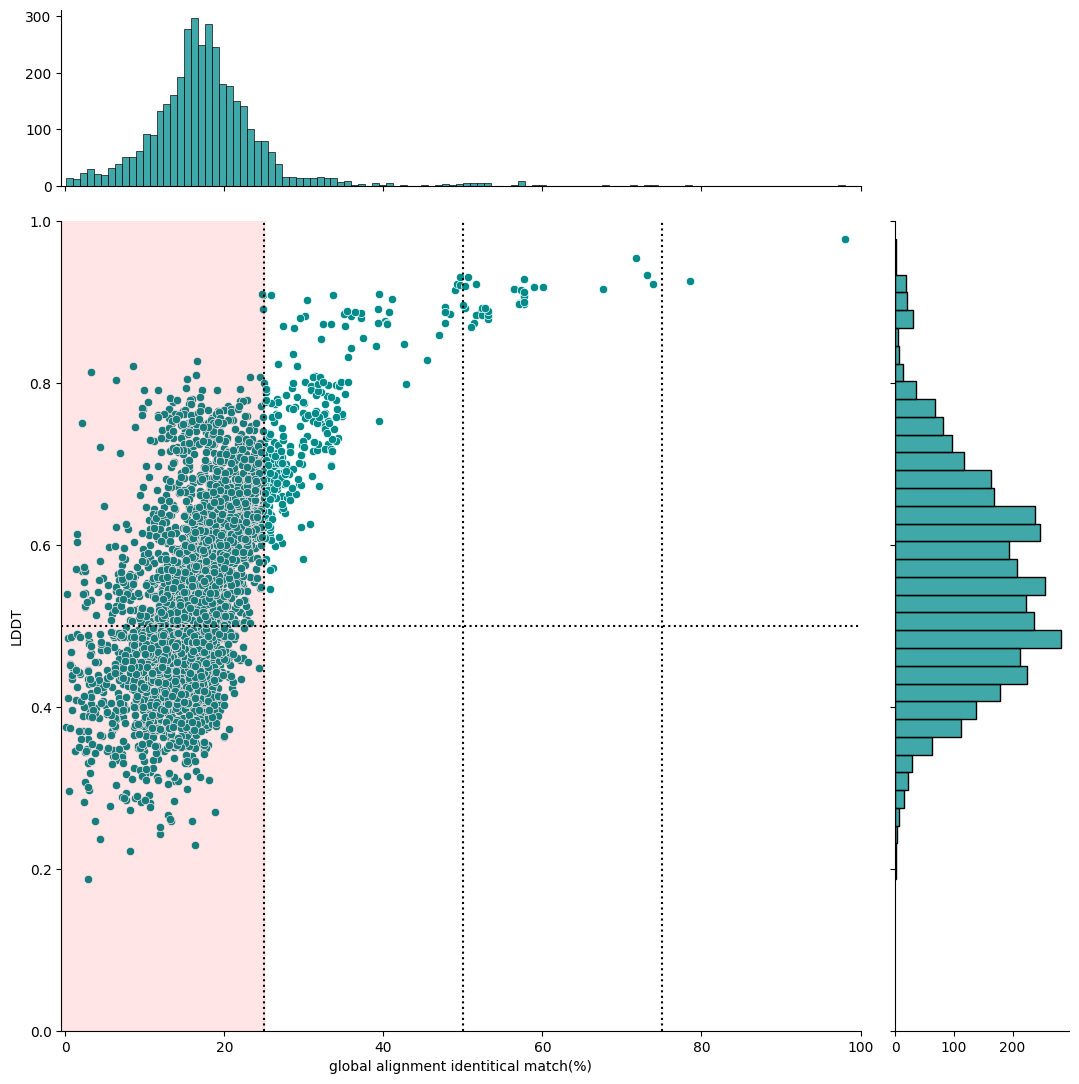

<Figure size 5000x5000 with 0 Axes>

In [19]:
foldseek_filter_viz = condition5.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
).unique().sort(
    by=["From"],
    descending=[False]
)

display(foldseek_filter_viz)

plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=foldseek_filter_viz,
    x="Identity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.fill_betweenx(
    y=[0, 15],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("global alignment identitical match(%)")
plt.ylabel("LDDT")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;

## InterPro Information

In [20]:
uniprot_info_rice = pl.read_csv(
    "../Data/Data_uniprot/rice_down_idmapping_20241004.tsv",
    separator='\t'
).select(
    "From",
    "InterPro"
).rename(
    {
        "From": "UniProt Accession",
        "InterPro": "InterPro_rice"
    }
).with_columns(
    pl.col("InterPro_rice").str.strip_suffix(";")
)

uniprot_info_human = pl.read_csv(
    "../Data/Data_uniprot/rice_down_human_idmapping_20241004.tsv",
    separator='\t'
).select(
    "From",
    "InterPro"
).rename(
    {
        "From": "foldseek hit",
        "InterPro": "InterPro_human"
    }
).with_columns(
    pl.col("InterPro_human").str.strip_suffix(";")
)

display(uniprot_info_rice.head())
display(uniprot_info_human.head())

UniProt Accession,InterPro_rice
str,str
"""A0A0P0UWX1""",null
"""A0A8J8YJH9""",null
"""Q5ZC68""",null
"""A0A0P0UXR3""","""IPR011009;IPR045874;IPR000719;…"
"""B7FAP2""","""IPR002213;IPR035595"""


foldseek hit,InterPro_human
str,str
"""A0A023PX70""","""IPR011009;IPR050198;IPR000719;…"
"""A0A024CIM4""","""IPR029058;IPR050654;IPR014788;…"
"""A0A024QY88""","""IPR000742;IPR007110;IPR036179;…"
"""A0A024QYV1""",null
"""A0A024QYY0""",null


In [21]:
domain_info_rice = foldseek_filter_viz.join(
    uniprot_info_rice,
    on="UniProt Accession",
    how="left",
    coalesce=True
)

domain_info = domain_info_rice.join(
    uniprot_info_human,
    on="foldseek hit",
    how="left",
    coalesce=True
).with_columns(
    pl.col("InterPro_rice").str.split(";").cast(pl.List(pl.Utf8)),
    pl.col("InterPro_human").str.split(";").cast(pl.List(pl.Utf8))
).with_columns( # https://docs.pola.rs/api/python/stable/reference/expressions/api/polars.Expr.list.set_intersection.html
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").alias("InterPro ID intersection"),
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").list.len().alias("InterPro ID intersection count")
).sort(
    by=["InterPro ID intersection count"],
    descending=True
).with_columns(
    pl.when(
        pl.col("InterPro ID intersection count") == 0
    ).then(
        pl.lit("no common InterPro ID")
    ).when(
        pl.col("InterPro ID intersection count") >= 3
    ).then(
        pl.lit("3 >= common InterPro ID")
    ).otherwise(
        pl.lit("3 < common InterPro ID")
    ).alias("InterPro ID intersection tag")
)

display(domain_info)

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,f64,f64,f64,f64,f64,f64,list[str],list[str],list[str],u32,str
"""Os01g0613500""","""Q9FTI3""","""P09668""",0.919,0.958,4.988,0.7318,34.3,35.3,"[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR025661"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]",7,"""3 >= common InterPro ID"""
"""Os01g0613500""","""Q9FTI3""","""P25774""",0.914,0.958,5.321,0.759,34.8,36.4,"[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR025661"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]",7,"""3 >= common InterPro ID"""
"""Os01g0613500""","""Q9FTI3""","""A0A7I2V2K3""",0.911,0.638,3.644,0.7266,22.1,35.4,"[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]",7,"""3 >= common InterPro ID"""
"""Os01g0613500""","""A0A0P0V569""","""A0A7I2V3M3""",0.944,0.678,14.09,0.675,20.5,35.5,"[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]",7,"""3 >= common InterPro ID"""
"""Os01g0613500""","""Q9FTI3""","""A0A7I2V4B6""",0.914,0.942,6.151,0.7625,32.7,35.8,"[""IPR038765"", ""IPR000169"", … ""IPR013201""]","[""IPR038765"", ""IPR025661"", … ""IPR013201""]","[""IPR038765"", ""IPR000169"", … ""IPR013201""]",7,"""3 >= common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""A6NGA9""",0.985,0.729,7.598,0.4847,9.7,33.3,"[""IPR006459"", ""IPR006702"", ""IPR044173""]","[""IPR050579""]",[],0,"""no common InterPro ID"""
"""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""",0.821,0.807,6.032,0.5904,10.4,31.0,"[""IPR006459"", ""IPR006702"", ""IPR044173""]","[""IPR029673""]",[],0,"""no common InterPro ID"""
"""Os12g0610800""","""Q0ILZ7""","""Q7Z7N9""",0.867,0.881,6.828,0.6059,17.9,23.6,"[""IPR006459"", ""IPR006702"", ""IPR044173""]","[""IPR029776""]",[],0,"""no common InterPro ID"""


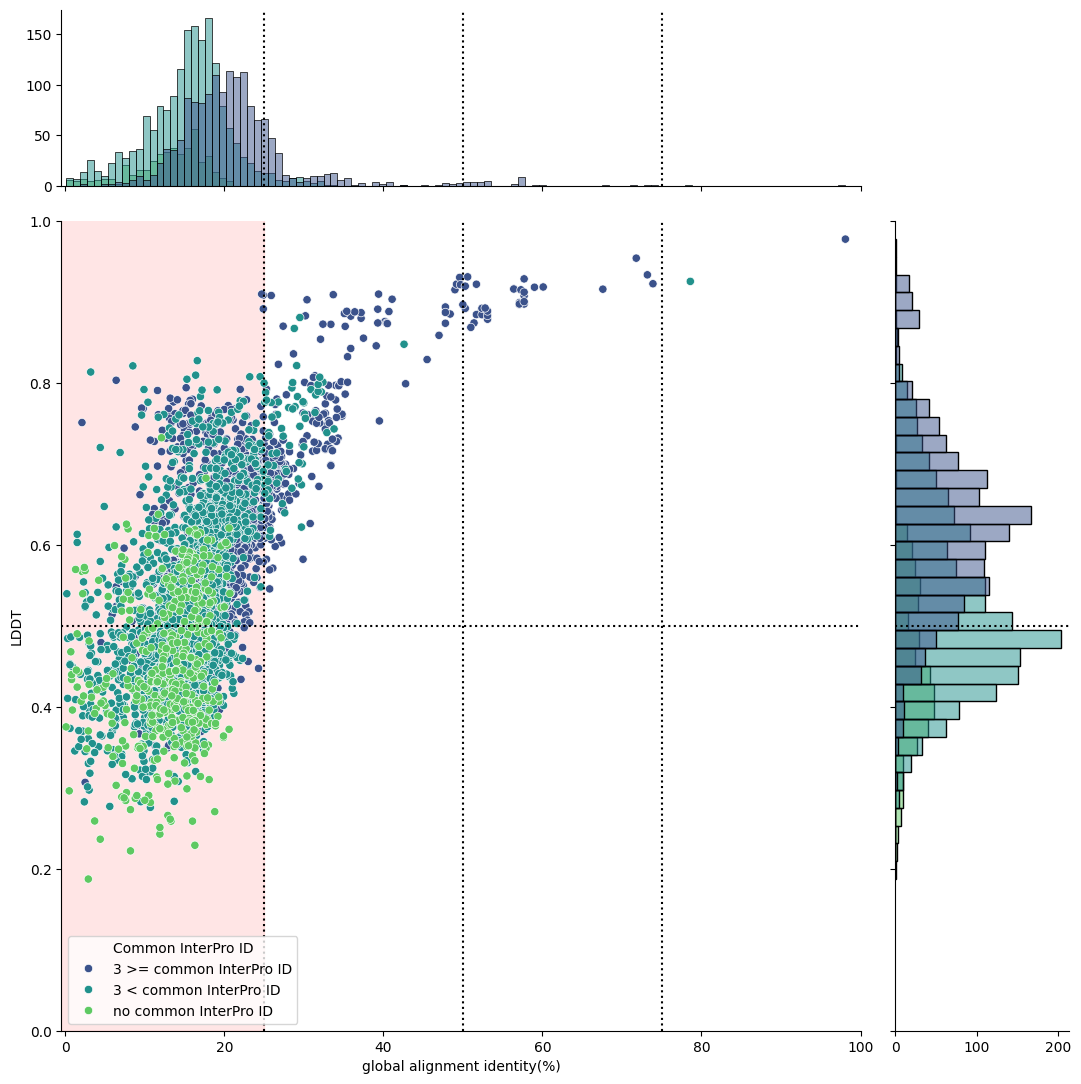

In [22]:
domain_info_viz = domain_info.drop(
    ["InterPro_rice", "InterPro_human"]
).to_pandas()

g = sns.JointGrid(
    data=domain_info_viz,
    x="Identity_percent_needle",
    y="lddt",
    hue="InterPro ID intersection tag",
    height=11,
    dropna=False,
    ratio=4,
    palette="viridis",
    marginal_ticks=True
)
g.ax_joint.set_xlim(-0.5,100)
g.ax_joint.set_ylim(0,1)
g.ax_joint.set_xlabel("global alignment identity(%)")
g.ax_joint.set_ylabel("LDDT")

g.ax_joint.fill_betweenx(
    y=[0, 15],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

g.refline(x=25, color="black", linestyle=":")
g.refline(x=50, color="black", linestyle=":")
g.refline(x=75, color="black", linestyle=":")
g.refline(y=0.5, color="black", linestyle=":")
g.plot(sns.scatterplot, sns.histplot)

# 呼び出し順に注意!!
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=labels, title='Common InterPro ID')

plt.show()

In [28]:
domain_info_filter = domain_info.filter(
    (pl.col("InterPro ID intersection count") == 0) &
    (pl.col("InterPro ID intersection tag") == "no common InterPro ID") &
    (
        (pl.col("InterPro_rice").is_null()) |
        (pl.col("InterPro_human").is_null())
    )
).sort(
    by=["lddt", "From"],
    descending=[True, False]
)

display(domain_info_filter)

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,InterPro_rice,InterPro_human,InterPro ID intersection,InterPro ID intersection count,InterPro ID intersection tag
str,str,str,f64,f64,f64,f64,f64,f64,list[str],list[str],list[str],u32,str
"""Os03g0431800""","""A0A0P0VZP7""","""A8MVZ6""",0.97,0.786,77.9,0.6823,17.7,19.5,null,"[""IPR018477""]",null,0,"""no common InterPro ID"""
"""Os04g0587500""","""A0A0P0WE19""","""Q96KT7""",0.905,0.944,6.309,0.6255,7.7,25.5,"[""IPR030182""]",null,null,0,"""no common InterPro ID"""
"""Os04g0587500""","""A0A0P0WE19""","""P0C7Q5""",0.913,0.953,7.277,0.617,15.6,22.5,"[""IPR030182""]",null,null,0,"""no common InterPro ID"""
"""Os04g0400000""","""A0A0N7KJ00""","""A6NFN3""",0.961,0.763,38.08,0.5991,6.2,28.8,null,"[""IPR025670"", ""IPR034237"", … ""IPR000504""]",null,0,"""no common InterPro ID"""
"""Os04g0400000""","""A0A0N7KJ00""","""F8VZG9""",1.0,0.588,39.71,0.5922,13.9,19.3,null,"[""IPR025670"", ""IPR034237"", … ""IPR000504""]",null,0,"""no common InterPro ID"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os07g0524200""","""Q69SA8""","""Q9BVX2""",0.887,0.676,14.31,0.5413,7.9,25.4,null,"[""IPR009790"", ""IPR048509"", ""IPR048511""]",null,0,"""no common InterPro ID"""
"""Os07g0524200""","""A0A0P0X782""","""Q9NUM4""",0.934,0.719,10.17,0.5154,12.3,19.1,null,"[""IPR009790"", ""IPR048509"", ""IPR048511""]",null,0,"""no common InterPro ID"""
"""Os07g0524200""","""Q69SA8""","""Q96A25""",0.92,0.706,15.0,0.5053,15.0,23.7,null,"[""IPR009790"", ""IPR048509"", ""IPR048511""]",null,0,"""no common InterPro ID"""


&nbsp;


&nbsp;

## Ensembl pan-homology information

- Ensembl pan-homologyの情報を追加する

In [29]:
ensembl_pan_homology = pl.read_csv(
    "../out/rice_down/rice_down_pan_homology_concat.tsv",
    separator='\t'
).rename(
    {
        "target_id": "ensembl_gene_id",
        "target_protein_id": "ensembl_protein_id"
    }
).select(
    "From",
    "method_link_type",
    "type",
    "ensembl_gene_id",
    "ensembl_protein_id"
)

print(ensembl_pan_homology.group_by(["From"]).n_unique())
display(ensembl_pan_homology)

shape: (98, 5)
┌──────────────┬──────────────────┬──────┬─────────────────┬────────────────────┐
│ From         ┆ method_link_type ┆ type ┆ ensembl_gene_id ┆ ensembl_protein_id │
│ ---          ┆ ---              ┆ ---  ┆ ---             ┆ ---                │
│ str          ┆ u32              ┆ u32  ┆ u32             ┆ u32                │
╞══════════════╪══════════════════╪══════╪═════════════════╪════════════════════╡
│ Os07g0561800 ┆ 1                ┆ 1    ┆ 22              ┆ 22                 │
│ Os06g0636700 ┆ 1                ┆ 1    ┆ 14              ┆ 14                 │
│ Os07g0129200 ┆ 1                ┆ 1    ┆ 14              ┆ 14                 │
│ Os03g0237100 ┆ 1                ┆ 1    ┆ 16              ┆ 16                 │
│ Os01g0696800 ┆ 1                ┆ 1    ┆ 9               ┆ 9                  │
│ …            ┆ …                ┆ …    ┆ …               ┆ …                  │
│ Os01g0179600 ┆ 1                ┆ 1    ┆ 22              ┆ 22                 │
│

From,method_link_type,type,ensembl_gene_id,ensembl_protein_id
str,str,str,str,str
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000135226""","""ENSP00000334276"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000171234""","""ENSP00000304811"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000135220""","""ENSP00000251566"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000213759""","""ENSP00000387683"""
"""Os01g0179600""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000173610""","""ENSP00000286604"""
…,…,…,…,…
"""Os12g0601800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000182158""","""ENSP00000329140"""
"""Os12g0601800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000107175""","""ENSP00000342136"""
"""Os12g0601800""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""ENSG00000157613""","""ENSP00000481956"""


In [30]:
condition6 = condition5.join(
    ensembl_pan_homology,
    on=["From", "ensembl_gene_id", "ensembl_protein_id"],
    how="left",
    coalesce=True
).with_columns(
    pl.col("type").fill_null("no homology info")
).sort(
    by=["From", "ensembl_gene_id"],
    descending=[False, False]
)

display(condition6)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id,method_link_type,type
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,str,str,i64,str,str,str
"""Os01g0179600""","""B7FAP2""","""P36537""",8.2570e-14,1.0,31,13.2,0.132,70,9,486,487,18,469,528,529,0.982,0.856,0.4525,0.5429,0.5052,0.581,11.72,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""SSGSCGKVLVWAAEYSLWMN-MKTILKELV…",331,"""0.486,0.588,0.492,0.477,0.592,…",200,695,"""55/200""","""97/695""",27.5,14.0,42.0,23.7,"""36/200""","""375/695""",18.0,54.0,138.0,84.5,"""ENSP00000413420""","""ENST00000458688""","""ENSG00000109181""",12544,"""UGT2B10""",null,"""no homology info"""
"""Os01g0179600""","""B7FAP2""","""P36537""",8.2570e-14,1.0,31,13.2,0.132,70,9,486,487,18,469,528,529,0.982,0.856,0.4525,0.5429,0.5052,0.581,11.72,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""SSGSCGKVLVWAAEYSLWMN-MKTILKELV…",331,"""0.486,0.588,0.492,0.477,0.592,…",200,695,"""55/200""","""97/695""",27.5,14.0,42.0,23.7,"""36/200""","""375/695""",18.0,54.0,138.0,84.5,"""ENSP00000265403""","""ENST00000265403""","""ENSG00000109181""",12544,"""UGT2B10""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
"""Os01g0179600""","""B7FAP2""","""Q6NUS8""",3.4400e-14,1.0,24,12.7,0.127,67,11,486,487,20,465,523,527,0.977,0.853,0.5215,0.6108,0.573,0.6618,6.876,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""NEAHHFLVVTYPAQGHINPARHLARRLARA…","""SEAAKILTISTLGGSHYLLLDRVSQILQE-…",328,"""0.492,0.461,0.493,0.665,0.685,…",213,639,"""57/213""","""100/639""",26.8,15.6,40.8,27.7,"""53/213""","""268/639""",24.9,41.9,151.0,127.5,"""ENSP00000487376""","""ENST00000625798""","""ENSG00000145626""",26625,"""UGT3A1""",null,"""no homology info"""
"""Os01g0179600""","""Q0JQ63""","""B7Z8Q8""",3.8470e-12,1.0,28,14.0,0.14,71,9,452,487,18,433,436,504,0.912,0.954,0.4899,0.5429,0.5982,0.6249,7.146,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""LLSEAAKILTISTLGGSHYLLLDRVSQILQ…",285,"""0.333,0.420,0.411,0.424,0.454,…",213,580,"""57/213""","""94/580""",26.8,16.2,40.8,28.8,"""53/213""","""237/580""",24.9,40.9,151.0,132.5,"""ENSP00000427079""","""ENST00000503189""","""ENSG00000145626""",26625,"""UGT3A1""",null,"""no homology info"""
"""Os01g0179600""","""B7FAP2""","""Q6NUS8""",3.4400e-14,1.0,24,12.7,0.127,67,11,486,487,20,465,523,527,0.977,0.853,0.5215,0.6108,0.573,0.6618,6.876,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""NEAHHFLVVTYPAQGHINPARHLARRLARA…","""SEAAKILTISTLGGSHYLLLDRVSQILQE-…",328,"""0.492,0.461,0.493,0.665,0.685,…",213,639,"""57/213""","""100/639""",26.8,15.6,40.8,27.7,"""53/213""","""268/639""",24.9,41.9,151.0,127.5,"""ENSP00000274278""","""ENST00000274278""","""ENSG00000145626""",26625,"""UGT3A1""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,0.821,0.807,0.5904,0.5441,0.4651,0.6474,6.032,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""DKLITLQPVVRACVFLATAVAAVIM-----…","""NNFLFAQCACYFLAFLFSFVVVVPLSENGH…",133,"""0.393,0.528,0.556,0.494,0.483,…",29,308,"""9/29""","""32/308""",31.0,10.4,55.2,17.5,"""4/29""","""188/308""",13.8,61.0,34

In [31]:
condition6 = condition6.with_columns(
    pl.when(
        pl.col("From").is_in(ensembl_pan_homology["From"]) # 遺伝子レベルで見たとき､Ensembl pan-homologyに対応しているかどうか
    ).then(
        pl.lit("pan-homology information")
    ).otherwise(
        pl.lit("no pan-homology information")
    ).alias("pan-homology information")
)

display(condition6)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id,method_link_type,type,pan-homology information
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,str,str,i64,str,str,str,str
"""Os01g0179600""","""B7FAP2""","""P36537""",8.2570e-14,1.0,31,13.2,0.132,70,9,486,487,18,469,528,529,0.982,0.856,0.4525,0.5429,0.5052,0.581,11.72,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""SSGSCGKVLVWAAEYSLWMN-MKTILKELV…",331,"""0.486,0.588,0.492,0.477,0.592,…",200,695,"""55/200""","""97/695""",27.5,14.0,42.0,23.7,"""36/200""","""375/695""",18.0,54.0,138.0,84.5,"""ENSP00000413420""","""ENST00000458688""","""ENSG00000109181""",12544,"""UGT2B10""",null,"""no homology info""","""pan-homology information"""
"""Os01g0179600""","""B7FAP2""","""P36537""",8.2570e-14,1.0,31,13.2,0.132,70,9,486,487,18,469,528,529,0.982,0.856,0.4525,0.5429,0.5052,0.581,11.72,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""SSGSCGKVLVWAAEYSLWMN-MKTILKELV…",331,"""0.486,0.588,0.492,0.477,0.592,…",200,695,"""55/200""","""97/695""",27.5,14.0,42.0,23.7,"""36/200""","""375/695""",18.0,54.0,138.0,84.5,"""ENSP00000265403""","""ENST00000265403""","""ENSG00000109181""",12544,"""UGT2B10""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""pan-homology information"""
"""Os01g0179600""","""B7FAP2""","""Q6NUS8""",3.4400e-14,1.0,24,12.7,0.127,67,11,486,487,20,465,523,527,0.977,0.853,0.5215,0.6108,0.573,0.6618,6.876,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""NEAHHFLVVTYPAQGHINPARHLARRLARA…","""SEAAKILTISTLGGSHYLLLDRVSQILQE-…",328,"""0.492,0.461,0.493,0.665,0.685,…",213,639,"""57/213""","""100/639""",26.8,15.6,40.8,27.7,"""53/213""","""268/639""",24.9,41.9,151.0,127.5,"""ENSP00000487376""","""ENST00000625798""","""ENSG00000145626""",26625,"""UGT3A1""",null,"""no homology info""","""pan-homology information"""
"""Os01g0179600""","""Q0JQ63""","""B7Z8Q8""",3.8470e-12,1.0,28,14.0,0.14,71,9,452,487,18,433,436,504,0.912,0.954,0.4899,0.5429,0.5982,0.6249,7.146,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""LLSEAAKILTISTLGGSHYLLLDRVSQILQ…",285,"""0.333,0.420,0.411,0.424,0.454,…",213,580,"""57/213""","""94/580""",26.8,16.2,40.8,28.8,"""53/213""","""237/580""",24.9,40.9,151.0,132.5,"""ENSP00000427079""","""ENST00000503189""","""ENSG00000145626""",26625,"""UGT3A1""",null,"""no homology info""","""pan-homology information"""
"""Os01g0179600""","""B7FAP2""","""Q6NUS8""",3.4400e-14,1.0,24,12.7,0.127,67,11,486,487,20,465,523,527,0.977,0.853,0.5215,0.6108,0.573,0.6618,6.876,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""NEAHHFLVVTYPAQGHINPARHLARRLARA…","""SEAAKILTISTLGGSHYLLLDRVSQILQE-…",328,"""0.492,0.461,0.493,0.665,0.685,…",213,639,"""57/213""","""100/639""",26.8,15.6,40.8,27.7,"""53/213""","""268/639""",24.9,41.9,151.0,127.5,"""ENSP00000274278""","""ENST00000274278""","""ENSG00000145626""",26625,"""UGT3A1""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""pan-homology information"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""Q6ZVK1""",0.02451,1.0,9,11.9,0.119,23,23,182,195,4,191,233,192,0.821,0.807,0.5904,0.5441,0.4651,0.6474,6.032,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""DKLITLQPVVR

In [32]:
condition6_v2 = condition6.with_columns(
    pl.when( # 遺伝子レベルで見たとき､すべてのヒットがEnsembl pan-homologyに対応しているかどうか
        (pl.col("method_link_type") == "ENSEMBL_ORTHOLOGUES").all().over("From") & (pl.col("method_link_type").is_not_null().all().over("From"))
    ).then(
        pl.lit("all hits are corresponding to Ensembl pan-homology")
    ).when( # 遺伝子レベルで見たとき､少なくとも1つのヒットがEnsembl pan-homologyに対応しているかどうか
        (pl.col("method_link_type") == "ENSEMBL_ORTHOLOGUES").any().over("From") & 
        ((pl.col("hgnc_id").n_unique().over("From") > 1) | (pl.col("ensembl_transcript_id").n_unique().over("From") > 1))
    ).then(
        pl.lit("have pan-homology info but also have other hits")
    ).when( # 遺伝子レベルで見たとき､Ensembl pan-homologyに対応しているが､対応するUniProt IDがない場合
        (pl.col("method_link_type").is_null().all().over("From")) & ((pl.col("pan-homology information") == "pan-homology information").over("From"))
    ).then(
        pl.lit("have pan-homology info but no corresponding protein hits")
    ).otherwise( # 遺伝子レベルで見たとき､すべてのヒットがEnsembl pan-homologyに対応していない場合
        pl.lit("have no pan-homology info")
    ).alias("gene_level_homology_info")
)

condition6_v2.write_csv(
    "../out/rice_down/foldseek_result_condition6.tsv",
    separator='\t'
)

display(condition6_v2)

From,UniProt Accession,foldseek hit,evalue,prob,gapopen,pident,fident,nident,qstart,qend,qlen,tstart,tend,tlen,alnlen,qcov,tcov,lddt,qtmscore,ttmscore,alntmscore,rmsd,taxid,taxname,taxlineage,qaln,taln,mismatch,lddtfull,Length_water,Length_needle,Identity_water,Identity_needle,Identity_percent_water,Identity_percent_needle,Similarity_percent_water,Similarity_percent_needle,Gaps_water,Gaps_needle,Gaps_percent_water,Gaps_percent_needle,Score_water,Score_needle,ensembl_protein_id,ensembl_transcript_id,ensembl_gene_id,hgnc_id,hgnc_symbol_id,method_link_type,type,pan-homology information,gene_level_homology_info
str,str,str,f64,f64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,i64,str,i64,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,str,str,i64,str,str,str,str,str
"""Os01g0179600""","""B7FAP2""","""P36537""",8.2570e-14,1.0,31,13.2,0.132,70,9,486,487,18,469,528,529,0.982,0.856,0.4525,0.5429,0.5052,0.581,11.72,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""SSGSCGKVLVWAAEYSLWMN-MKTILKELV…",331,"""0.486,0.588,0.492,0.477,0.592,…",200,695,"""55/200""","""97/695""",27.5,14.0,42.0,23.7,"""36/200""","""375/695""",18.0,54.0,138.0,84.5,"""ENSP00000413420""","""ENST00000458688""","""ENSG00000109181""",12544,"""UGT2B10""",null,"""no homology info""","""pan-homology information""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""P36537""",8.2570e-14,1.0,31,13.2,0.132,70,9,486,487,18,469,528,529,0.982,0.856,0.4525,0.5429,0.5052,0.581,11.72,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""SSGSCGKVLVWAAEYSLWMN-MKTILKELV…",331,"""0.486,0.588,0.492,0.477,0.592,…",200,695,"""55/200""","""97/695""",27.5,14.0,42.0,23.7,"""36/200""","""375/695""",18.0,54.0,138.0,84.5,"""ENSP00000265403""","""ENST00000265403""","""ENSG00000109181""",12544,"""UGT2B10""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""pan-homology information""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""Q6NUS8""",3.4400e-14,1.0,24,12.7,0.127,67,11,486,487,20,465,523,527,0.977,0.853,0.5215,0.6108,0.573,0.6618,6.876,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""NEAHHFLVVTYPAQGHINPARHLARRLARA…","""SEAAKILTISTLGGSHYLLLDRVSQILQE-…",328,"""0.492,0.461,0.493,0.665,0.685,…",213,639,"""57/213""","""100/639""",26.8,15.6,40.8,27.7,"""53/213""","""268/639""",24.9,41.9,151.0,127.5,"""ENSP00000487376""","""ENST00000625798""","""ENSG00000145626""",26625,"""UGT3A1""",null,"""no homology info""","""pan-homology information""","""have pan-homology info but als…"
"""Os01g0179600""","""Q0JQ63""","""B7Z8Q8""",3.8470e-12,1.0,28,14.0,0.14,71,9,452,487,18,433,436,504,0.912,0.954,0.4899,0.5429,0.5982,0.6249,7.146,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""VANEAHHFLVVTYPAQGHINPARHLARRLA…","""LLSEAAKILTISTLGGSHYLLLDRVSQILQ…",285,"""0.333,0.420,0.411,0.424,0.454,…",213,580,"""57/213""","""94/580""",26.8,16.2,40.8,28.8,"""53/213""","""237/580""",24.9,40.9,151.0,132.5,"""ENSP00000427079""","""ENST00000503189""","""ENSG00000145626""",26625,"""UGT3A1""",null,"""no homology info""","""pan-homology information""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""Q6NUS8""",3.4400e-14,1.0,24,12.7,0.127,67,11,486,487,20,465,523,527,0.977,0.853,0.5215,0.6108,0.573,0.6618,6.876,9606,"""Homo sapiens""","""-_cellular organisms;d_Eukaryo…","""NEAHHFLVVTYPAQGHINPARHLARRLARA…","""SEAAKILTISTLGGSHYLLLDRVSQILQE-…",328,"""0.492,0.461,0.493,0.665,0.685,…",213,639,"""57/213""","""100/639""",26.8,15.6,40.8,27.7,"""53/213""","""268/639""",24.9,41.9,151.0,127.5,"""ENSP00000274278""","""ENST00000274278""","""ENSG00000145626""",26625,"""UGT3A1""","""ENSEMBL_ORTHOLOGUES""","""ortholog_many2many""","""pan-homology information""","""have pan-homology info but als…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12

In [33]:
foldseek_filter_viz = condition6_v2.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_water",
    "Similarity_percent_needle",
    "Score_water",
    "Score_needle",
    "type",
    "gene_level_homology_info"
).unique(
    subset=["From", "UniProt Accession", "foldseek hit", "gene_level_homology_info"]
).sort(
    by=["From", "UniProt Accession", "foldseek hit", "gene_level_homology_info"],
    descending=[False, False, False, False]
)

display(foldseek_filter_viz)

From,UniProt Accession,foldseek hit,qcov,tcov,rmsd,lddt,Identity_percent_needle,Identity_percent_water,Similarity_percent_water,Similarity_percent_needle,Score_water,Score_needle,type,gene_level_homology_info
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""Os01g0179600""","""B7FAP2""","""A0A140T9Z0""",0.986,0.896,28.01,0.3342,15.7,23.1,33.4,25.7,126.0,89.5,"""no homology info""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""O60656""",0.977,0.836,7.592,0.4974,15.9,26.0,43.5,27.7,145.5,121.0,"""ortholog_many2many""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""O75310""",0.979,0.851,8.478,0.4855,13.5,27.5,41.5,23.5,135.0,82.0,"""ortholog_many2many""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""O75795""",0.979,0.853,8.602,0.4812,12.8,24.7,42.0,21.2,137.5,96.5,"""ortholog_many2many""","""have pan-homology info but als…"
"""Os01g0179600""","""B7FAP2""","""P06133""",0.982,0.856,11.88,0.4475,15.2,26.4,38.9,27.4,137.5,83.0,"""no homology info""","""have pan-homology info but als…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Os12g0610800""","""Q0ILZ7""","""A6NGA9""",0.985,0.729,7.598,0.4847,9.7,33.3,57.1,19.3,33.0,16.5,"""no homology info""","""have no pan-homology info"""
"""Os12g0610800""","""Q0ILZ7""","""O43760""",0.856,0.777,9.35,0.5329,7.3,29.7,45.9,13.0,31.0,22.0,"""no homology info""","""have no pan-homology info"""
"""Os12g0610800""","""Q0ILZ7""","""O43761""",0.805,0.638,6.696,0.5363,5.4,29.5,41.0,8.2,34.0,14.5,"""no homology info""","""have no pan-homology info"""


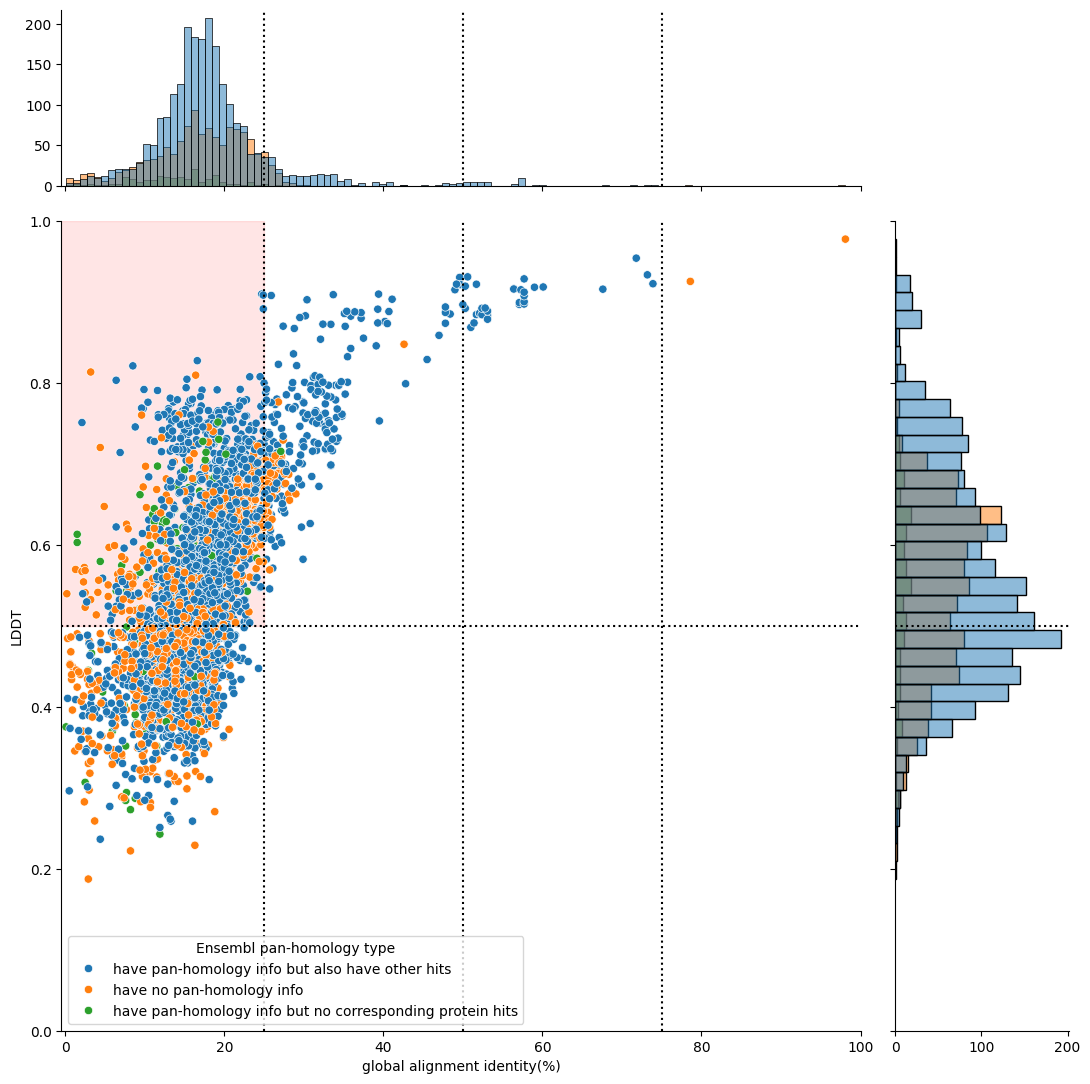

In [35]:
# Ensembl pan-homologyの有無による散布図
g = sns.JointGrid(
    data=foldseek_filter_viz,
    x="Identity_percent_needle",
    y="lddt",
    hue="gene_level_homology_info",
    height=11,
    dropna=False,
    ratio=4,
    marginal_ticks=True
)
g.ax_joint.set_xlim(-0.5,100)
g.ax_joint.set_ylim(0,1)
g.ax_joint.set_xlabel("global alignment identity(%)")
g.ax_joint.set_ylabel("LDDT")

g.ax_joint.fill_betweenx(
    y=[0.5, 1],
    x1=-0.5,
    x2=25,
    color="red",
    alpha=0.1
)

g.refline(x=25, color="black", linestyle=":")
g.refline(x=50, color="black", linestyle=":")
g.refline(x=75, color="black", linestyle=":")
g.refline(y=0.5, color="black", linestyle=":")
g.plot(sns.scatterplot, sns.histplot)

# 呼び出し順に注意!!
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=labels, title='Ensembl pan-homology type')

plt.show()

In [37]:
# pan_homology_filter = condition6_v2.filter(
#     (pl.col("gene_level_homology_info") == "have no pan-homology info") &
#     (pl.col("lddt") >= 0.5) &
#     (pl.col("Identity_percent_needle") <= 25) &
#     (pl.col("InterPro ID intersection count") == 0)
# ).sort(
#     by=["lddt", "From"],
#     descending=[True, False]
# )

# pan_homology_filter_tsv = pan_homology_filter.with_columns(
#     pl.col("InterPro_rice").map_elements(
#         lambda x: ", ".join(x), return_dtype=pl.Utf8
#     ),
#     pl.col("InterPro_human").map_elements(
#         lambda x: ", ".join(x), return_dtype=pl.Utf8
#     ),
#     pl.col("InterPro ID intersection").map_elements(
#         lambda x: ", ".join(x), return_dtype=pl.Utf8
#     )
# ).write_csv(
#     "../out/rice_up/pan_homology_filter.tsv",
#     separator='\t'
# )

# display(pan_homology_filter)

&nbsp;

&nbsp;

&nbsp;

--------------------------------

&nbsp;

&nbsp;

# 11. Condition7

- HN-scoreの情報を追加する
- サンプルごとに算出したHN-scoreのデータを追加する

In [ ]:
HNscore_rice_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_validate_HN5_rice.tsv",
    separator='\t'
).rename(
    {
        "GENEID": "From"
    }
)

display(HNscore_rice_sample.head())

In [ ]:
condition7 = condition6_v2.join(
    HNscore_rice_sample,
    on="From",
    how="left",
    coalesce=True
).sort(
    by=["HN5(all)"],
    descending=False
)

display(condition7.head())


&nbsp;

&nbsp;

# ヒトとマウスのHN-scoreの情報を追加する

- 先に、foldseekでヒットしたUniProt IDに対応するデータをフィルタリングしておく

In [ ]:
HNscore_human_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_human_checked.tsv",
    separator="\t"
)

HNscore_mouse_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_mouse_checked.tsv",
    separator="\t"
)

display(HNscore_human_sample.head())
display(HNscore_mouse_sample.head())


In [ ]:
HNscore_hm_combine = HNscore_human_sample.join(
    HNscore_mouse_sample,
    on=["uniprot_id", "ensembl_protein_id", "ensembl_transcript_id", "ensembl_gene_id", "hgnc_id"],
    how="left",
    coalesce=True,
    suffix="_mouse"
).select(
    [
        "uniprot_id",
        "ensembl_protein_id",
        "ensembl_transcript_id",
        "ensembl_gene_id",
        "hgnc_id",
        "GENEID",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_mouse",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "positive_contribution_human",
        "positive_contribution_mouse",
        "negative_contribution_human",
        "negative_contribution_mouse"
    ]
).rename(
    {
        "uniprot_id": "foldseek hit",
        "GENEID": "hgnc_symbol_id"
    }
).unique().sort(
    by=["HN5(all)", "HN5(all)_mouse"],
    descending=[False, False]
)

display(HNscore_hm_combine.head())

In [ ]:
condition7_v2 = condition7.join(
    HNscore_hm_combine,
    on=["foldseek hit", "ensembl_protein_id", "ensembl_transcript_id", "ensembl_gene_id", "hgnc_id", "hgnc_symbol_id"],
    how="left",
    coalesce=True,
    suffix="_human"
).filter( # ヒトとマウスのHN-scoreが両方ともnullでないもののみ残す
    pl.col("HN5(all)_human").is_not_null() &
    pl.col("HN5(all)_mouse").is_not_null()
)

display(condition7_v2.head())

&nbsp;

&nbsp;


## 12. フィルタリングする

- イネ､ヒトそれぞれのHN-scoreが､集めたサンプルの1/3以上から貢献しているヒットを選抜する

In [ ]:
condition7_v3 = condition7_v2.filter(
    (pl.col("Identity_percent_needle") <= 25) &
    (pl.col("lddt") >= 0.5) &
    (pl.col("negative_samples_count") >= 5) &
    (
    (pl.col("negative_samples_count_human") >= 15) |
    (pl.col("negative_samples_count_mouse") >= 15)
    )
)

display(condition7_v3)

&nbsp;

&nbsp;